In [1]:
from Model.DCVAE import DCVAE
from Model.Utils import PlotHistory, PlotDataAE, Save_Model
from Model.Utils import load_from_tfrecords, convert_to_tfrecords, load_numpy
from keras.optimizers import RMSprop,Adam
import numpy as np
# from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
%matplotlib notebook

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# Load DataSet

In [2]:
load_tfrecords = True 
create_tfrecords = False

path_tfr = 'DataSet/MPS60'
path_npy = '/share/GeoFacies/ModelosDeFacies/ModelMPS60/DataSet/DataSet.npy'
batch_size = 32

In [3]:
if load_tfrecords:
    if create_tfrecords: 
        x_train, x_test = load_numpy(path_npy,random_state=0,split_data=0.30)
        convert_to_tfrecords(path_tfr, x_train, x_test)
        gen_train, gen_test = load_from_tfrecords(path_tfr, batch_size)
    else:
        try:
            gen_train, gen_test = load_from_tfrecords(path_tfr, batch_size)
        except:
            print("Data not found. Change 'create_tfrecords' to True")
else:
    x_train, x_test = load_numpy(path_npy,random_state=0,split_data=0.30)

# Create Convolutional Variational Autoencoder

In [4]:
path_weights = os.path.join(path_tfr, 'w60.hdf5')

model = DCVAE(input_shape=(60, 60, 2),filters=[128,64,32],strides=[2,2,1],KernelDim=(3,3,3),hidden_dim=2048,
              latent_dim=500,opt=Adam(lr=0.0001),dropout=0.1,epochs_drop=200, filepath=path_weights)

# Training Network

In [5]:
num_epochs = 500
if load_tfrecords:
    x_train = gen_train.mps_generator()
    x_val = gen_test.mps_generator()
    model.fit_generator(x_train,
                        num_epochs=num_epochs, verbose=1, 
                        steps_per_epoch = len(gen_train),
                        val_set = x_val,
                        validation_steps = len(gen_test))
else:
    model.fit(x_train, num_epochs=num_epochs, batch_size = batch_size, x_v=x_test,verbose=1) 

Setting up model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 60, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 128)  2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 15, 15, 64)   73792       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 15, 15, 32)   18464       conv2d_2

Epoch 1/500


437/437 [==============================] - 25s 58ms/step - loss: 1782.3934 - acc_pred: 0.7494 - val_loss: 1139.0572 - val_acc_pred: 0.8694
Epoch 2/500


437/437 [==============================] - 21s 48ms/step - loss: 1010.9937 - acc_pred: 0.8919 - val_loss: 892.9270 - val_acc_pred: 0.9091
Epoch 3/500


437/437 [==============================] - 21s 48ms/step - loss: 870.8510 - acc_pred: 0.9130 - val_loss: 815.2849 - val_acc_pred: 0.9204
Epoch 4/500


437/437 [==============================] - 20s 47ms/step - loss: 814.8873 - acc_pred: 0.9209 - val_loss: 776.6692 - val_acc_pred: 0.9248
Epoch 5/500


437/437 [==============================] - 20s 46ms/step - loss: 778.6083 - acc_pred: 0.9258 - val_loss: 750.8830 - val_acc_pred: 0.9286
Epoch 6/500


437/437 [==============================] - 20s 46ms/step - loss: 754.8199 - acc_pred: 0.9289 - val_loss: 729.2731 - val_acc_pred: 0.9304
Epoch 7/500


437/437 [==============================] - 20s 46ms/step - loss: 737.4795 - acc_pred: 0.9312 - val_loss: 713.5609 - val_acc_pred: 0.9333
Epoch 8/500


437/437 [==============================] - 20s 46ms/step - loss: 719.6662 - acc_pred: 0.9334 - val_loss: 696.9520 - val_acc_pred: 0.9358
Epoch 9/500


437/437 [==============================] - 20s 46ms/step - loss: 704.4063 - acc_pred: 0.9352 - val_loss: 679.7324 - val_acc_pred: 0.9376
Epoch 10/500


437/437 [==============================] - 20s 46ms/step - loss: 689.3687 - acc_pred: 0.9370 - val_loss: 673.9334 - val_acc_pred: 0.9379
Epoch 11/500


437/437 [==============================] - 20s 46ms/step - loss: 676.0049 - acc_pred: 0.9385 - val_loss: 660.0238 - val_acc_pred: 0.9399
Epoch 12/500


437/437 [==============================] - 20s 47ms/step - loss: 664.3192 - acc_pred: 0.9398 - val_loss: 648.1765 - val_acc_pred: 0.9411
Epoch 13/500


437/437 [==============================] - 21s 48ms/step - loss: 652.7386 - acc_pred: 0.9411 - val_loss: 637.4887 - val_acc_pred: 0.9419
Epoch 14/500


437/437 [==============================] - 21s 48ms/step - loss: 642.4327 - acc_pred: 0.9421 - val_loss: 629.9550 - val_acc_pred: 0.9426
Epoch 15/500


437/437 [==============================] - 21s 48ms/step - loss: 632.0382 - acc_pred: 0.9432 - val_loss: 619.8314 - val_acc_pred: 0.9443
Epoch 16/500


437/437 [==============================] - 21s 47ms/step - loss: 621.2520 - acc_pred: 0.9442 - val_loss: 611.3991 - val_acc_pred: 0.9445
Epoch 17/500


437/437 [==============================] - 21s 48ms/step - loss: 612.4880 - acc_pred: 0.9451 - val_loss: 602.5719 - val_acc_pred: 0.9462
Epoch 18/500


437/437 [==============================] - 21s 47ms/step - loss: 602.8369 - acc_pred: 0.9461 - val_loss: 591.9636 - val_acc_pred: 0.9471
Epoch 19/500


437/437 [==============================] - 20s 46ms/step - loss: 594.6123 - acc_pred: 0.9469 - val_loss: 587.8009 - val_acc_pred: 0.9462
Epoch 20/500


437/437 [==============================] - 20s 46ms/step - loss: 585.9883 - acc_pred: 0.9478 - val_loss: 581.2417 - val_acc_pred: 0.9478
Epoch 21/500


437/437 [==============================] - 20s 46ms/step - loss: 578.5775 - acc_pred: 0.9485 - val_loss: 571.8865 - val_acc_pred: 0.9483
Epoch 22/500


437/437 [==============================] - 20s 46ms/step - loss: 570.7447 - acc_pred: 0.9493 - val_loss: 566.5912 - val_acc_pred: 0.9489
Epoch 23/500


437/437 [==============================] - 20s 46ms/step - loss: 563.1661 - acc_pred: 0.9499 - val_loss: 558.5840 - val_acc_pred: 0.9501
Epoch 24/500


437/437 [==============================] - 20s 46ms/step - loss: 556.9297 - acc_pred: 0.9505 - val_loss: 553.5582 - val_acc_pred: 0.9503
Epoch 25/500


437/437 [==============================] - 20s 46ms/step - loss: 550.0360 - acc_pred: 0.9512 - val_loss: 545.9589 - val_acc_pred: 0.9509
Epoch 26/500


437/437 [==============================] - 20s 46ms/step - loss: 543.5826 - acc_pred: 0.9518 - val_loss: 541.2106 - val_acc_pred: 0.9516
Epoch 27/500


437/437 [==============================] - 20s 47ms/step - loss: 537.6529 - acc_pred: 0.9524 - val_loss: 535.8105 - val_acc_pred: 0.9518
Epoch 28/500


437/437 [==============================] - 20s 46ms/step - loss: 532.0827 - acc_pred: 0.9529 - val_loss: 531.9479 - val_acc_pred: 0.9520
Epoch 29/500


437/437 [==============================] - 20s 46ms/step - loss: 526.0794 - acc_pred: 0.9535 - val_loss: 531.0931 - val_acc_pred: 0.9528
Epoch 30/500


437/437 [==============================] - 20s 46ms/step - loss: 520.9888 - acc_pred: 0.9540 - val_loss: 523.9683 - val_acc_pred: 0.9536
Epoch 31/500


437/437 [==============================] - 21s 47ms/step - loss: 516.3871 - acc_pred: 0.9545 - val_loss: 520.1449 - val_acc_pred: 0.9532
Epoch 32/500


437/437 [==============================] - 21s 48ms/step - loss: 512.6766 - acc_pred: 0.9548 - val_loss: 516.0921 - val_acc_pred: 0.9543
Epoch 33/500


437/437 [==============================] - 21s 47ms/step - loss: 508.4225 - acc_pred: 0.9553 - val_loss: 513.2126 - val_acc_pred: 0.9536
Epoch 34/500


437/437 [==============================] - 21s 48ms/step - loss: 502.4438 - acc_pred: 0.9558 - val_loss: 509.6872 - val_acc_pred: 0.9542
Epoch 35/500


437/437 [==============================] - 21s 48ms/step - loss: 499.4452 - acc_pred: 0.9562 - val_loss: 507.3301 - val_acc_pred: 0.9547
Epoch 36/500


437/437 [==============================] - 21s 47ms/step - loss: 495.2789 - acc_pred: 0.9565 - val_loss: 504.7637 - val_acc_pred: 0.9551
Epoch 37/500


437/437 [==============================] - 21s 47ms/step - loss: 491.8178 - acc_pred: 0.9569 - val_loss: 502.5394 - val_acc_pred: 0.9546
Epoch 38/500


437/437 [==============================] - 20s 46ms/step - loss: 487.7218 - acc_pred: 0.9573 - val_loss: 499.2195 - val_acc_pred: 0.9554
Epoch 39/500


437/437 [==============================] - 20s 46ms/step - loss: 484.2870 - acc_pred: 0.9576 - val_loss: 497.4978 - val_acc_pred: 0.9554
Epoch 40/500


437/437 [==============================] - 20s 46ms/step - loss: 480.8357 - acc_pred: 0.9580 - val_loss: 494.1753 - val_acc_pred: 0.9564
Epoch 41/500


437/437 [==============================] - 20s 46ms/step - loss: 478.0844 - acc_pred: 0.9583 - val_loss: 495.2880 - val_acc_pred: 0.9560
Epoch 42/500


437/437 [==============================] - 20s 46ms/step - loss: 475.2747 - acc_pred: 0.9585 - val_loss: 490.8854 - val_acc_pred: 0.9564
Epoch 43/500


437/437 [==============================] - 20s 46ms/step - loss: 471.5722 - acc_pred: 0.9589 - val_loss: 490.1521 - val_acc_pred: 0.9563
Epoch 44/500


437/437 [==============================] - 20s 46ms/step - loss: 468.4671 - acc_pred: 0.9592 - val_loss: 486.2686 - val_acc_pred: 0.9566
Epoch 45/500


437/437 [==============================] - 20s 46ms/step - loss: 466.3814 - acc_pred: 0.9595 - val_loss: 485.7933 - val_acc_pred: 0.9565
Epoch 46/500


437/437 [==============================] - 20s 46ms/step - loss: 463.8078 - acc_pred: 0.9596 - val_loss: 485.9937 - val_acc_pred: 0.9573
Epoch 47/500


437/437 [==============================] - 21s 47ms/step - loss: 461.0464 - acc_pred: 0.9600 - val_loss: 483.0839 - val_acc_pred: 0.9574
Epoch 48/500


437/437 [==============================] - 21s 48ms/step - loss: 457.9752 - acc_pred: 0.9603 - val_loss: 482.8400 - val_acc_pred: 0.9573
Epoch 49/500


437/437 [==============================] - 20s 47ms/step - loss: 455.6906 - acc_pred: 0.9605 - val_loss: 482.8736 - val_acc_pred: 0.9574
Epoch 50/500


437/437 [==============================] - 20s 46ms/step - loss: 452.5762 - acc_pred: 0.9609 - val_loss: 479.4954 - val_acc_pred: 0.9571
Epoch 51/500


437/437 [==============================] - 20s 46ms/step - loss: 450.7605 - acc_pred: 0.9611 - val_loss: 478.5778 - val_acc_pred: 0.9571
Epoch 52/500


437/437 [==============================] - 20s 46ms/step - loss: 447.8987 - acc_pred: 0.9613 - val_loss: 478.5837 - val_acc_pred: 0.9574
Epoch 53/500


437/437 [==============================] - 20s 46ms/step - loss: 445.1538 - acc_pred: 0.9616 - val_loss: 481.8519 - val_acc_pred: 0.9576
Epoch 54/500


437/437 [==============================] - 20s 46ms/step - loss: 443.5227 - acc_pred: 0.9618 - val_loss: 477.8241 - val_acc_pred: 0.9581
Epoch 55/500


437/437 [==============================] - 20s 47ms/step - loss: 441.2522 - acc_pred: 0.9621 - val_loss: 476.2545 - val_acc_pred: 0.9578
Epoch 56/500


437/437 [==============================] - 21s 47ms/step - loss: 439.0426 - acc_pred: 0.9623 - val_loss: 473.5249 - val_acc_pred: 0.9579
Epoch 57/500


437/437 [==============================] - 21s 48ms/step - loss: 436.9605 - acc_pred: 0.9625 - val_loss: 473.4041 - val_acc_pred: 0.9583
Epoch 58/500


437/437 [==============================] - 21s 48ms/step - loss: 434.7599 - acc_pred: 0.9627 - val_loss: 474.4249 - val_acc_pred: 0.9579
Epoch 59/500


437/437 [==============================] - 21s 47ms/step - loss: 432.3084 - acc_pred: 0.9630 - val_loss: 472.6401 - val_acc_pred: 0.9578
Epoch 60/500


437/437 [==============================] - 21s 48ms/step - loss: 430.4393 - acc_pred: 0.9632 - val_loss: 473.0528 - val_acc_pred: 0.9579
Epoch 61/500


437/437 [==============================] - 21s 47ms/step - loss: 428.6724 - acc_pred: 0.9634 - val_loss: 472.1031 - val_acc_pred: 0.9582
Epoch 62/500


437/437 [==============================] - 20s 46ms/step - loss: 426.3824 - acc_pred: 0.9636 - val_loss: 472.4720 - val_acc_pred: 0.9582
Epoch 63/500


437/437 [==============================] - 20s 46ms/step - loss: 425.4347 - acc_pred: 0.9637 - val_loss: 472.0958 - val_acc_pred: 0.9583
Epoch 64/500


437/437 [==============================] - 20s 46ms/step - loss: 423.6142 - acc_pred: 0.9639 - val_loss: 473.7559 - val_acc_pred: 0.9580
Epoch 65/500


437/437 [==============================] - 20s 46ms/step - loss: 421.5862 - acc_pred: 0.9641 - val_loss: 472.4538 - val_acc_pred: 0.9581
Epoch 66/500


437/437 [==============================] - 20s 46ms/step - loss: 419.9436 - acc_pred: 0.9643 - val_loss: 469.5409 - val_acc_pred: 0.9584
Epoch 67/500


437/437 [==============================] - 20s 46ms/step - loss: 417.7066 - acc_pred: 0.9645 - val_loss: 470.0255 - val_acc_pred: 0.9583
Epoch 68/500


437/437 [==============================] - 20s 46ms/step - loss: 416.5200 - acc_pred: 0.9647 - val_loss: 470.4309 - val_acc_pred: 0.9583
Epoch 69/500


437/437 [==============================] - 20s 47ms/step - loss: 414.2185 - acc_pred: 0.9649 - val_loss: 469.6641 - val_acc_pred: 0.9585
Epoch 70/500


437/437 [==============================] - 20s 46ms/step - loss: 413.4546 - acc_pred: 0.9650 - val_loss: 469.3719 - val_acc_pred: 0.9585
Epoch 71/500


437/437 [==============================] - 20s 46ms/step - loss: 410.7916 - acc_pred: 0.9653 - val_loss: 468.4529 - val_acc_pred: 0.9587
Epoch 72/500


437/437 [==============================] - 20s 47ms/step - loss: 410.2711 - acc_pred: 0.9654 - val_loss: 468.3478 - val_acc_pred: 0.9588
Epoch 73/500


437/437 [==============================] - 21s 47ms/step - loss: 408.2520 - acc_pred: 0.9656 - val_loss: 468.5809 - val_acc_pred: 0.9583
Epoch 74/500


437/437 [==============================] - 21s 47ms/step - loss: 406.2536 - acc_pred: 0.9658 - val_loss: 470.4531 - val_acc_pred: 0.9587
Epoch 75/500


437/437 [==============================] - 21s 48ms/step - loss: 404.9275 - acc_pred: 0.9660 - val_loss: 470.3570 - val_acc_pred: 0.9586
Epoch 76/500


437/437 [==============================] - 21s 48ms/step - loss: 403.7564 - acc_pred: 0.9661 - val_loss: 471.3820 - val_acc_pred: 0.9581
Epoch 77/500


437/437 [==============================] - 21s 47ms/step - loss: 402.1475 - acc_pred: 0.9663 - val_loss: 477.3632 - val_acc_pred: 0.9578

Epoch 00077: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 78/500


437/437 [==============================] - 20s 46ms/step - loss: 394.9223 - acc_pred: 0.9672 - val_loss: 465.6296 - val_acc_pred: 0.9590
Epoch 79/500


437/437 [==============================] - 20s 46ms/step - loss: 390.6669 - acc_pred: 0.9677 - val_loss: 464.0110 - val_acc_pred: 0.9592
Epoch 80/500


437/437 [==============================] - 20s 46ms/step - loss: 388.6978 - acc_pred: 0.9679 - val_loss: 465.5314 - val_acc_pred: 0.9595
Epoch 81/500


437/437 [==============================] - 20s 46ms/step - loss: 387.8570 - acc_pred: 0.9680 - val_loss: 464.0569 - val_acc_pred: 0.9592
Epoch 82/500


437/437 [==============================] - 20s 46ms/step - loss: 386.5559 - acc_pred: 0.9682 - val_loss: 464.6165 - val_acc_pred: 0.9595
Epoch 83/500


437/437 [==============================] - 20s 47ms/step - loss: 385.1065 - acc_pred: 0.9683 - val_loss: 465.7300 - val_acc_pred: 0.9591
Epoch 84/500


437/437 [==============================] - 20s 46ms/step - loss: 384.0152 - acc_pred: 0.9684 - val_loss: 465.7613 - val_acc_pred: 0.9594

Epoch 00084: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 85/500


437/437 [==============================] - 20s 46ms/step - loss: 380.6061 - acc_pred: 0.9689 - val_loss: 464.8320 - val_acc_pred: 0.9597
Epoch 86/500


437/437 [==============================] - 20s 47ms/step - loss: 379.0628 - acc_pred: 0.9691 - val_loss: 464.4004 - val_acc_pred: 0.9596
Epoch 87/500


437/437 [==============================] - 21s 48ms/step - loss: 378.0689 - acc_pred: 0.9692 - val_loss: 464.4503 - val_acc_pred: 0.9594
Epoch 88/500


437/437 [==============================] - 21s 48ms/step - loss: 377.1105 - acc_pred: 0.9693 - val_loss: 465.4398 - val_acc_pred: 0.9598
Epoch 89/500


437/437 [==============================] - 21s 48ms/step - loss: 376.6013 - acc_pred: 0.9694 - val_loss: 465.5774 - val_acc_pred: 0.9597

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



# Ploting Train History

val_loss   :  [464.8320077498329, 464.4003648400944, 464.4503128133356, 465.4398359818892]
loss   :  [380.6061207926246, 379.0627769627342, 378.0688968195795, 377.1105142763605]


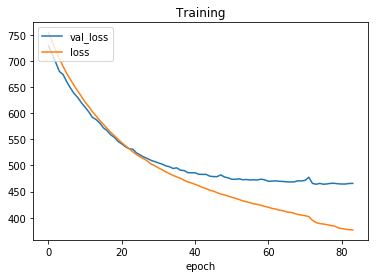

In [6]:
PlotHistory(model.history.history,listKeys=['val_loss','loss']) 

val_acc_pred   :  [0.9596794709802311, 0.9595832407155777, 0.9593590319475388, 0.959761585781281]
acc_pred   :  [0.9688996948148347, 0.9690954551544015, 0.9692214697394819, 0.969319540657768]


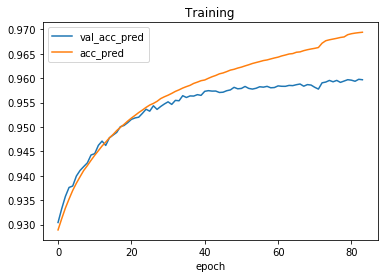

In [7]:
PlotHistory(model.history.history,listKeys=['val_acc_pred','acc_pred'])

lr   :  [2.5e-05, 2.5e-05, 2.5e-05, 2.5e-05]


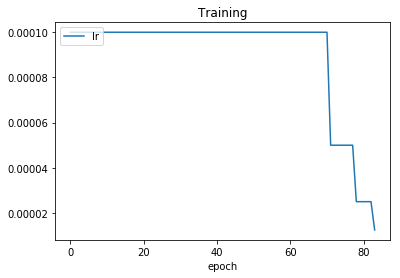

In [8]:
PlotHistory(model.history.history,listKeys=['lr'])

# Evaluate Model with Test dataset 

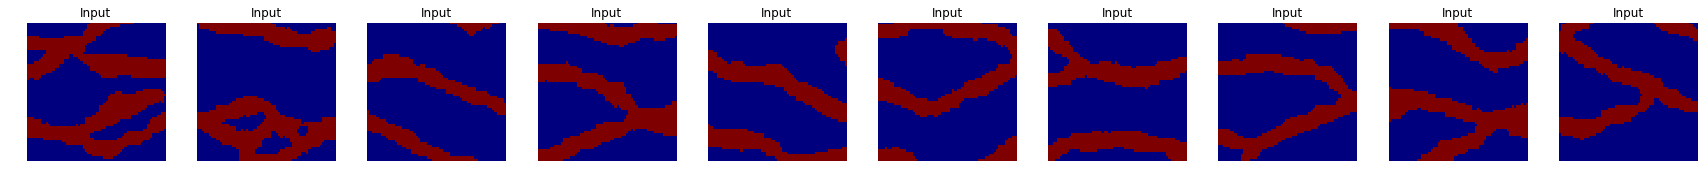

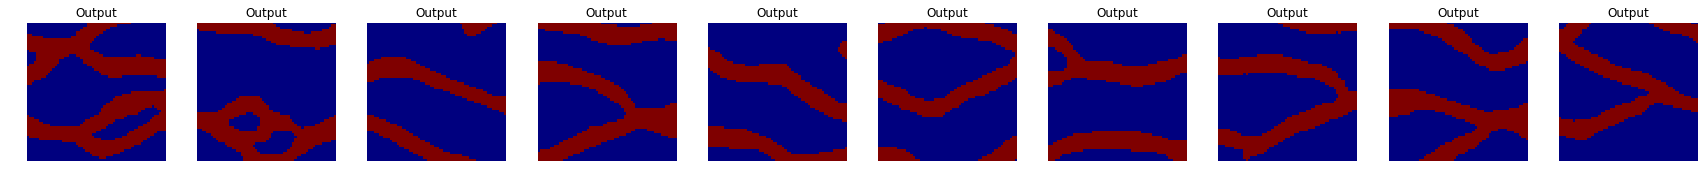

In [9]:
if load_tfrecords:
    x_test = gen_test.get_numpy_batch()

x_rec = model.model.predict(x_test)
PlotDataAE(np.argmax(x_test[:,:,:,:],axis=-1),np.argmax(x_rec[:,:,:,:],axis=-1),digit_size=(60,60))

# Generate random sampling

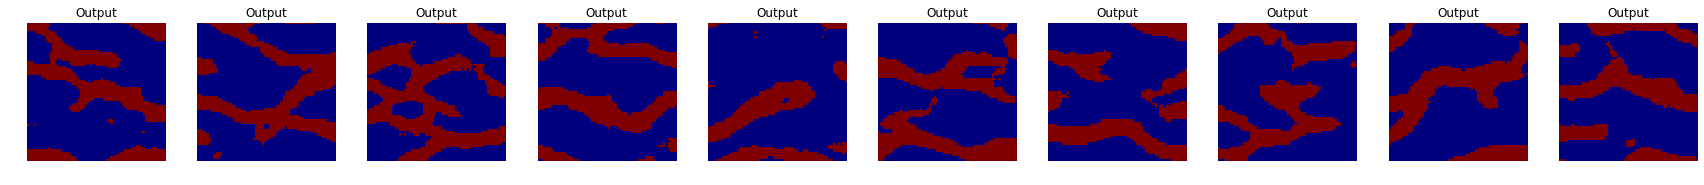

In [10]:
x_gen=model.generate(binary=True)
PlotDataAE([],x_gen[:,:,:],digit_size=(60,60),Only_Result=False)